## Comparision Topic Modeling using Watson NLP & Latent Dirichlet Allocation (LDA) 


This notebook demonstrates how to analyze consumer financial data using Watson NLP & LDA. Here we will see how Topic Modeling is working with Watson_NLP & Latent Dirichlet Allocation (LDA)

The data that is used in this notebook is taken from the the [Consumer complaint database](https://www.consumerfinance.gov/data-research/consumer-complaints). The dataset has been downloaded and saved in the [Box folder](https://ibm.box.com/shared/static/m9fczhrugyjgn45ez4upgntakevt7wmj.csv) for you.



### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). The syntax block performs NLP primitive tasks on the input text. It uses Izumo, the standard NLP primitives component of Watson NLP to perform the following tasks:
    1. Sentence detection
    1. Tokenization: can't -> ca + n't
    1. Part-of-Speech tagging: I thought -> I/PRON, thought/VERB
    1. Lemmatization: I thought -> I/I, thought/think
    1. Dependency parsing: I -> nsubj -> thought -> root


- **Heirarchical Clustering** with the _HierarchicalClustering_ block. Topic Modeling consists of two models; a summary model and a topic model. Topic modeling starts with summarization after constructing a conversation structure from input data. Ngram based summaries are generated after applying refining procedures conversations. Then, the topic modeler applies hierarchical clustering using conversation vectors from the corpus of summaries.
    1. **Summary Model**: The summary model takes as input a processed syntax document (using the WatsonNLP Izumo block). Additionally, there are a number of training parameters that can be supplied alongside the syntax document to adjust the summary model. 
    
    1. **Topic Model**: Topic Model creates a tree of topics from the input data (summary model) by iteratively splitting broader topics to narrower topics (diagram below). This process is achieved using a hierarchical document clustering algorithm ((i.e. HierarchicalClustering block). Unlike other topic modeling algorithms such as Latent Dirichlet Allocation (LDA), the users do not provide fixed number of topics that may not be known to them but controls how the iterative/hierarchical topic discovery and splitting happens. This form of topic modeling is preferred over LDA when a user is not sure how many topics their dataset consists of.Three key parameters are used for this purpose: num_topics_per_iteration will determine how many topics will be extracted at each iteration of the hierarchical process. If after the first iteration there are no topics that are too large according to the king_cluster_min_ratio and min_records_per_king_cluster values and needs to be further split, then the num_topics_per_iteration will be the upper bound on the final number of topics. Otherwise, at least another iteration of the clustering will be performed to further split topics that are too large.
    
    2. **Latent Dirichlet Allocation (LDA)** : LDA is an unsupervised clustering technique that is commonly used for text analysis. It’s a type of topic modeling in which words are represented as topics, and documents are represented as a collection of these word topics.

## Table of Contents


1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing & EDA](#EDA)
    1.  [Text Pre-Processing](#TextPre)
1.  [Phrase & Keywords Extraction](#Phrase)
1.  [Model Building](#loadandpredict)
    1.  [Training a Summary Model](#loadandpredictsummary)
    1.  [Hierarchical Topic Modeling ](#loadandpredicthier)
    1.  [Save Model](#loadandpredictsave)
    1.  [Load Model](#loadandpredictload)
1.  [Case Study](#casestudy)
    1.  [Case Study -Analysis 2 company hot topics & phrases](#casestudy1)
    1.  [Case Study - Analysis company topics & phrases month wise](#casestudy2)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [1]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [2]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [3]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp
from datetime import datetime

<a id="loadData"></a>
## 2. Data Loading (consumer complaints)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Topic modeling on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet">We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This data set contains 999285 consumer complaints with the date received,product,sub-product, submitted via and company information.</span>

In [4]:
# load data set into a dataframe
url = "https://ibm.box.com/shared/static/umtlj2bmdysnnr4ejftqzrvgsubaswg8.csv"
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# preview the data set
complaint_df.head()

Unnamed: 0 Date received  \
0          14    2022-03-07   
1          16    2022-03-21   
2          20    2022-03-06   
3          21    2022-03-07   
4          25    2022-05-29   

                                                                        Product  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1                                                               Debt collection   
2                                                   Checking or savings account   
3  Credit reporting, credit repair services, or other personal consumer reports   
4  Credit reporting, credit repair services, or other personal consumer reports   

        Sub-product  \
0  Credit reporting   
1  Credit card debt   
2  Checking account   
3  Credit reporting   
4  Credit reporting   

                                                                              Issue  \
0                                              Incorrect information on your report   
1                                                 Attempts to collect debt not owed   
2                                                               Managing an account   
3  Problem with a credit reporting company's investigation into an existing problem   
4                                              Incorrect information on your report   

                                                 Sub-issue  \
0                      Information belongs to someone else   
1                                        Debt is not yours   
2                                 Deposits and withdrawals   
3  Their investigation did not fix an error on your report   
4                      Information belongs to someone else   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX  section 

<a id="EDA"></a>
## 3. Data Processing & EDA

<span style="color:blueviolet">Convert the recieved date into date time format</span>

In [5]:
for index in range(len(complaint_df['Date received'])):
    date_str = complaint_df['Date received'][index]
    complaint_df.at[index,'Date received'] =datetime.strptime(date_str, '%Y-%m-%d')

complaint_df.head()

Unnamed: 0        Date received  \
0          14  2022-03-07 00:00:00   
1          16  2022-03-21 00:00:00   
2          20  2022-03-06 00:00:00   
3          21  2022-03-07 00:00:00   
4          25  2022-05-29 00:00:00   

                                                                        Product  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1                                                               Debt collection   
2                                                   Checking or savings account   
3  Credit reporting, credit repair services, or other personal consumer reports   
4  Credit reporting, credit repair services, or other personal consumer reports   

        Sub-product  \
0  Credit reporting   
1  Credit card debt   
2  Checking account   
3  Credit reporting   
4  Credit reporting   

                                                                              Issue  \
0                                              Incorrect information on your report   
1                                                 Attempts to collect debt not owed   
2                                                               Managing an account   
3  Problem with a credit reporting company's investigation into an existing problem   
4                                              Incorrect information on your report   

                                                 Sub-issue  \
0                      Information belongs to someone else   
1                                        Debt is not yours   
2                                 Deposits and withdrawals   
3  Their investigation did not fix an error on your report   
4                      Information belongs to someone else   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLA

In [6]:
# Adding the columns reagarding month & year so we can extract company data through the month & year
complaint_df['Month'] = pd.DatetimeIndex(complaint_df['Date received']).month
complaint_df['Year'] = pd.DatetimeIndex(complaint_df['Date received']).year
complaint_df.head()

Unnamed: 0        Date received  \
0          14  2022-03-07 00:00:00   
1          16  2022-03-21 00:00:00   
2          20  2022-03-06 00:00:00   
3          21  2022-03-07 00:00:00   
4          25  2022-05-29 00:00:00   

                                                                        Product  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1                                                               Debt collection   
2                                                   Checking or savings account   
3  Credit reporting, credit repair services, or other personal consumer reports   
4  Credit reporting, credit repair services, or other personal consumer reports   

        Sub-product  \
0  Credit reporting   
1  Credit card debt   
2  Checking account   
3  Credit reporting   
4  Credit reporting   

                                                                              Issue  \
0                                              Incorrect information on your report   
1                                                 Attempts to collect debt not owed   
2                                                               Managing an account   
3  Problem with a credit reporting company's investigation into an existing problem   
4                                              Incorrect information on your report   

                                                 Sub-issue  \
0                      Information belongs to someone else   
1                                        Debt is not yours   
2                                 Deposits and withdrawals   
3  Their investigation did not fix an error on your report   
4                      Information belongs to someone else   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLA

In [7]:
# To see how the companies are getting complaints 
exp_company = complaint_df.explode('Company')

<span style="color:purple">Extract most frequent companies in the dataset</span>

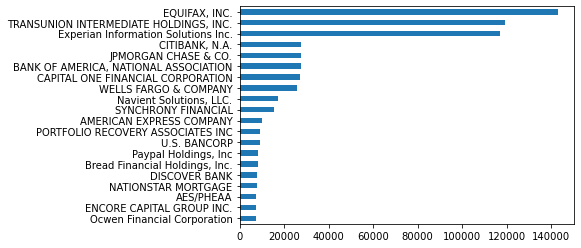

In [8]:
top_company_names =exp_company['Company'].value_counts().head(20)
top_company_names.sort_values().plot(kind='barh') 
plt.show()

In [9]:
print(top_company_names)

EQUIFAX, INC.                             143202
TRANSUNION INTERMEDIATE HOLDINGS, INC.    119124
Experian Information Solutions Inc.       116763
CITIBANK, N.A.                             27583
JPMORGAN CHASE & CO.                       27552
BANK OF AMERICA, NATIONAL ASSOCIATION      27486
CAPITAL ONE FINANCIAL CORPORATION          26980
WELLS FARGO & COMPANY                      25993
Navient Solutions, LLC.                    17146
SYNCHRONY FINANCIAL                        15676
AMERICAN EXPRESS COMPANY                   10153
PORTFOLIO RECOVERY ASSOCIATES INC           9318
U.S. BANCORP                                9277
Paypal Holdings, Inc                        8248
Bread Financial Holdings, Inc.              8136
DISCOVER BANK                               7715
NATIONSTAR MORTGAGE                         7607
AES/PHEAA                                   7413
ENCORE CAPITAL GROUP INC.                   7322
Ocwen Financial Corporation                 7268
Name: Company, dtype

<a id="TextPre"></a>
## 3.1 Text Pre-Processing
Our first step is to pre-process the documents in a way that cleans distracting signals and makes them easier to process and analyze. This is a standard step in many NLP pipelines. Here we perform two types of pre-processing:

1. Stop-words filtering
1. Remove Some Patterns 
1. Lemmatization

### 3.1.1 Stop-Words Filtering
    Stop-words are common words that are unmeaningful for separating the data. Such common words are assumed to be "noise" as their high frequency could hide the words carrying more informative signal. We filter   them based on a pre-defined list used in WatsonNLP and based on the part-of-speech. Notes:

    1. The stop-words list can be customized for the target dataset. We demonstrate this below.
    1. When we vectorize the documents below, we apply a filter that ignores terms that appear in 50% or more of the documents. This filter can also be counted as part of stop-words filtering.

### 3.1.2 Remove some Patterns
       1. This dataset has consumer personal information also . that is hide by Pattern of 'XX/XX/XXXX' or other date . So replacing this pattern as well.

### 3.1.3  Lemmatization
    Variability in surface forms, as in derivation (drive, driving, drives) and inflection (am, is, are), creates a challenge for a clustering algorithm that works on top of term frequency (TF) representations since in this setup the algorithm is not aware of the strong semantic relation between them. By lemmatizing the data, we group together different word forms by their lemma, thus ignoring subtle differences between them, but capturing their common concept. Example of lemmatization:

    1. Derivation: all instances of drive, driving and drives would become drive
    1. Inflection: all instances of am, is, are would become be

We rely on WatsonNLP's stock list of stop-words and customize it. For example, we might assume that a word like 'keep' can be useful for separating the data, so we remove it from the list. In addition, we might want to add a few other words to the list. For instance, common informal contractions that aren't part of the stock list.

In [10]:
# added sub-products & products into stop word list to know more about what people are talking about
wnlp_stop_words = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock').stopwords
stop_words = list(wnlp_stop_words)
stop_words.extend(["gimme", "lemme", "cause", "'cuz", "imma", "gonna", "wanna", 
                   "gotta", "hafta", "woulda", "coulda", "shoulda", "howdy","day"])
stop_words.extend(complaint_df['Sub-product'].unique().tolist())
stop_words.extend(complaint_df['Product'].unique().tolist())
stop_words.extend(["chase","credit card", "company","day","bank","hour","express",'credit','card','SYNCHRONY FINANCIAL'.lower(),'synchrony','financial'])
stop_words.extend(["Ocwen Financial Corporation".lower(), "Ocwen".lower(),"corporation","financial corporation","Paypal Holdings, Inc".lower(),"paypal","holdings","paypal holdings"])

<span style="color:purple">Define a custom list of Izumo part-of-speech tags that will be used for filtering</span>

In [11]:
pos_filter = {
    4,      # POS_AUX
    10,     # POS_PART
    11,     # POS_PRON
    15,     # POS_SYM
    17      # POS_X
}

<span style="color:purple">Now we define a tokenizer that implements the pre-processing as explained above. The input for the tokenizer is the document text and the output is a list of lemmas, while ignoring stop-words.</span>

In [12]:
# load the syntex model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

In [13]:
def custom_tokenizer(text):
    # parse the text for pos tagging and lemmatization
    result = syntax_model.run(text, parsers=('part_of_speech', 'lemma'))

    # collect the terms that qualify as meaningful.
    # to qualify, a term must meet all conditions:
    # (a) not be pos-tagged as symbol / content-less word
    # (b) not be a stop-word from the pre-defined list
    # (c) be longer than 1 character
    terms = []
    for token in result.tokens:
        pos_tag = token.part_of_speech
        if pos_tag not in pos_filter:
            lemma = token.lemma.strip()
            text = token.span.text.strip()
            term = lemma if len(lemma) > 0 else text
            if len(term) >1:
                terms.append(term)
    return " ".join(terms)

In [14]:
# Pre-processing steps for document level only remove stop words  & Patterns which is find they are comman
def clean(doc):
    stop_free = " ".join([word.replace('X','').replace('/','') for word in doc.split() if word.lower() not in stop_words])
    return stop_free

In [15]:
# getting names of top companies 
top_company_names_list =[]
for index,row in top_company_names.items():
    top_company_names_list.append(index)
    
print("Company Name ---",top_company_names_list[9]) 

Company Name --- SYNCHRONY FINANCIAL


In [16]:
# extarct company data through the company name 
def extarct_company_data(company_name):
    top_doc_list =[]
    for index, row in complaint_df.iterrows():
        if row['Company'] == company_name:
            top_doc_list.append(row['Consumer complaint narrative']) 
    return top_doc_list
    

In [17]:
# extracting data for comapny 'SYNCHRONY FINANCIAL'
top_doc_list = extarct_company_data(top_company_names_list[9])

In [18]:
len(top_doc_list)

15676

<span style="color:purple">Apply pre-processing steps to whole data before processing to extract the keywords & Noun Phrases</span>

In [19]:
top_complaint_df = [clean(doc) for doc in top_doc_list] 

In [20]:
# Create a Word Cloud 
def create_word_cloud(top_level_cat_df,text):
    figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
    wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(top_level_cat_df.value_counts().head(20))
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    ax1.title.set_text(text)
    plt.show()

<a id="loadandpredict"></a>
## 4. Model Building using Watson_NLP

<span style="color:purple">Import required libraries for Topic modeling</span>

In [21]:
from watson_nlp.toolkit import NGramSummary
from watson_nlp.blocks.topics import HierarchicalClustering
from watson_core import data_model as dm

<span style="color:purple">Loaded stopwords list for using topic modling</span>

In [22]:
url = "https://ibm.box.com/shared/static/ox03f0sv5m3rwu33d84rrcdzmtgsdfd3.txt"
topic_model_stopwords = pd.read_csv(url,delimiter="\n",encoding='utf-8')

<a id="loadandpredictsummary"></a>
### 5.1 Training a Summary Model 

<span style="color:purple"> Train a summary model using the <strong> izumo syntax data</strong> as data inputs.</span>

A summary model consists of a mapping of words to their occurrences over all of the documents

Additionally, the summary model can be provided a dictionary of parameters to modify the summary model that is trained. 

<span style="color:purple">These train parameters are: </span>
    <p>1. min_words_per_utterance: int, documents with fewer words than this value are removed</p>
    <p>2. num_turns_to_remove: int, initial number of turns to be removed from analysis (useful in conversation kind of data where initial few turns are typically greetings)</p>
    <p>3. beginning_ratio: int ratio of the document from the beginning to be weighted differently </p>
    <p>4. beginning_weighting_factor: int, weighting factor for the beginning portion of the training procedure</p>
    <p>5. beginning_min_count: int, minimum count of ngrams for beginning portion of the training procedure</p>
    <p>6. rest_weighting_factor: int, weighting factor for the remaining portion of the training procedure</p>
    <p>7. rest_min_count: int, minimum count of ngrams for the remaining portion of the training procedure</p>
    <p>8. min_ngram_size: int, minimum size of list of ngrams to generate summaries for each document</p>
    <p>9. max_ngram_size: int, maximum size of list of ngrams to generate summaries for each document</p>
    <p>10. max_ngrams: int, maximum number of ngrams for each document summary</p>
    <p>11. lang: str, language</p>
    <p>12. stopwords: list, set of stopwords for the model to ignore when generating topic clusters</p>

<span style="color:purple">These are supplied as a dictionary the the train_params parameter. E.g. </span>

>{
>    'min_words_per_utterance': 5,
>    'num_turns_to_remove': 0,
>    'beginning_ratio': 1,
>    'beginning_weighting_factor': 1,
>    'min_ngram_size': 5,
>    'max_ngram_size': 8,
>    'max_ngrams': 10,
>}

In [23]:
train_params = {
    "min_words_per_utterance": 10,
    "num_turns_to_remove": 0,
    "beginning_ratio": 1,
    "beginning_weighting_factor": 1,
    "min_ngram_size": 2,
    "max_ngram_size": 3,
    "max_ngrams": 10,
    'stopwords': list(topic_model_stopwords)
}

<span style="color:purple">Convert dataframe into the required format for training the model</span>

In [24]:
complaint_df_up = pd.DataFrame(top_complaint_df)
train_file = './train_data.csv'
complaint_df_up.to_csv(train_file)

complaint_df_up.head()

0
0  Received letter  stating closed. states reason " Activity account ( ) indicative high risk failure pay ''. date closing, {$580.00} cash back. called, stated close account. makes sense reason legit account opened 2 months. limit {$15000.00}. balance 2021 {$9900.00} due date . entire balanced {$9900.00} paid  ( transaction detail statement ). statement balance {$0.00} charged paid statement clos...
1  TJ Maxx-Synchrony account 20 years. middle end  problem receiving mailed payments timely manner payments 1 week advance due date. late payment resolved   reversed late charge finance charge. time moved time mailing payments approximately 2 weeks 1 week receiving bill Synchrony.  bill charged late fee finance charge. total  bill approximately {$4100.00}. previous balance {$2100.00} received tim...
2  started noticed unauthorized charge :  unauthorized charge {$180.00}, called in, Navy made adjustment day. requested protection.  navy transferred balance previous card, {$220.00}, card-I fine that. impression takes balance transfer. balance carried  ( ) matches  balance transfer.  make 4 returns person amounts : - {$83.00} - {$19.00} - {$25.00} - {$96.00} pay entire balances month expected 4 ...
3                                                                                                                                                                                                                                                                                                                                                                                               APPLY  MUST FRAUD.
4             Pursuant 15 usc 1681 ( ) ( ) comply reasonable procedures meet commerce. report fair, equitable me. information Confidential proof receiving pre-qualification offers companies, soft inquiries companies agreed business information relevant, accurate improperly used, comply subchapter FCRA ( Fair Reporting Act ) remedy injuries caused me, save time money court demanding : delete accounts

In [25]:
csv_stream = dm.DataStream.from_csv(train_file, skip=1)
syntax_data = syntax_model.stream(csv_stream[1])

In [26]:
summary_model = NGramSummary.train(train_data=syntax_data,train_params=train_params)

You can look into some of the details of the summary model such as the specifications of the model. For example: summary_model.model.get_n_grams() will return information about the length of the n-grams. The n-grams are the set of tokens

><p>max_N_gram_size: int, max length of the n-grams for each document e.g. if set to 5: ['I', 'was', 'travelling', 'last', 'week'] (n-gram length = 5)</p>
><p>min_N_gram_size: int, min length of the n-grams for each document e.g. if set to 3: ['bank', 'account', 'issue'] (n-gram length = 3)</p>
><p>max_N_grams: int, maximum number of n-grams for each document e.g 10 </p>

In [27]:
summary_model.model.get_n_grams()

{'max_N_gram_size': 3, 'min_N_gram_size': 2, 'max_N_grams': 10}

<a id="loadandpredicthier"></a>
### 5. 2  Hierarchical Topic Modeling 
<span style="color:purple">Train a hierarchical topic model by supplying the izumo <strong>syntax data and the summary model</strong></span>

Optional model parameters can be supplied to train the topic model: 

1. num_topics_per_iteration: int, number of topics for each run (fixed across all runs)

2. king_cluster_min_ratio: float, define cluster as a king cluster if the percentage of documents belonging to a specific cluster is greater than this value. A king cluster can be considered a "most prominent" cluster that other clusters would be correlated with

3. min_records_per_king_cluster: int, define cluster as a king cluster if the number of documents belonging to a specific cluster is greater than this value

4. max_num_iters_per_model: int, maximum number of iterations

5. min_word_support: float, minimum word support for each run of the model

6. max_word_support: float, maximum word support for each run of the model

7. max_ngrams_per_topic: int, maximum number of ngrams per topic</ol>

<span style="color:purple">These parameters can be supplied to the train() function as a dictionary such as below:</span>

>train_params = {
>    'king_cluster_min_ratio': .5,
>    'min_records_per_king_cluster': 10,
>    'num_topics_per_iteration': 40,
>    'max_num_iters_per_model': 4,
>    'min_word_support': 0.01,
>    'max_word_support': 0.7,
>    'max_ngrams_per_topic': 10,
>}

In [28]:
topic_model = HierarchicalClustering.train(train_data=syntax_data, 
                                           summary_model=summary_model,
                                           train_params = {'king_cluster_min_ratio': 1.0, 
                                                           'min_records_per_king_cluster': 5000,
                                                           'num_topics_per_iteration': 15,
                                                           'max_num_iters_per_model': 10,
                                                           'max_ngrams_per_topic':15})

<span style="color:purple">Showing result of Topic Model with only First cluster</span>

In [29]:
topic_model_output =topic_model.model.to_json_summary()
print(json.dumps(topic_model_output['clusters'][0], indent=2))

{
  "clusterId": 0,
  "numDocuments": 227.0,
  "percentage": 2.0183159953765446,
  "cohesiveness": 2.172240128162185,
  "modelWords": [
    "report (report),0.5984445214271545",
    "inquiry (inquiry),0.054762981832027435",
    "account (account),0.028892673552036285",
    "removed (removed),0.020624462515115738",
    "hard (hard),0.018249886110424995",
    "consumer (consumer),0.017984909936785698",
    "information (information),0.011959044262766838"
  ],
  "modelNgram": [
    "inquiry report hard,2.3678008318348054",
    "inquiry report,2.1766209884405305",
    "report account,2.090415830510321",
    "report information,1.7972960518395873",
    "removed report,1.6337585396103191",
    "report consumer,1.531769593121291",
    "removed Inquiry report,1.0844907123271519",
    "report Hard,0.8549199797035183",
    "inquiry hard,0.319025919033607",
    "removed inquiry,0.2090183779953683",
    "information account,0.14860164332417566"
  ],
  "modelId": 0,
  "topicName": "remove_inquiry_r

<span style="color:purple">Extract all the Topic names , Keywords , Phrases & Sentences from the Topic Model</span>

In [30]:
#  Extracting all Topic names , Keywords , Phrases & Sentences from the Topic Model
def extract_topics_information(topic_model_output):
    topic_dict=[]
    for topic in topic_model_output['clusters']:
        topic_val = {'Topic Name':topic['topicName'],'Total Documents':topic['numDocuments'],'Percentage':topic['percentage'],'Cohesiveness':topic['cohesiveness'],'Keywords':topic['modelWords'],'Phrases':topic['modelNgram'],'Sentences':topic['sentences']}
        topic_dict.append(topic_val)
    return topic_dict


#### Showing Top Topics with Keywords , Pharses & Sentecnes for company

<span style="color:purple">Convert the dictionary created above into a dataframe</span>

In [31]:
# Convert topic_dict into data frame to see which are the most imprtnat topics with Keywords & Phrases & SENTENSES (SORT BY Percentage)
topic_df = pd.DataFrame(extract_topics_information(topic_model_output))
topic_df=topic_df.sort_values("Percentage",ascending=False)
topic_df.head()


Topic Name  Total Documents  Percentage  Cohesiveness  \
12              month_paid_balance           5262.0   46.785810      0.299995   
6   Account_number_charges_account           1691.0   15.035120      0.687482   
8     payment_thought_written_made            885.0    7.868765      0.566902   
5                 charged_late_fee            448.0    3.983284      0.577222   
1         interest_balance_charged            412.0    3.663199      1.252872   

                                                                                                                                                                                                                                                                        Keywords  \
12         [balance (balance),0.030905701220035553, pay (pay),0.02765657566487789, paid (paid),0.02362179569900036, account (account),0.022067425772547722, called (called),0.019320683553814888, payments (payments),0.01928015425801277, amount (amount),0.018876424059271812]   
6      [account (account),0.3739657402038574, closed (closed),0.05773642659187317, opened (opened),0.022858820855617523, number (number),0.019220860674977303, balance (balance),0.017151663079857826, paid (paid),0.017021896317601204, payment (payment),0.015912260860204697]   
8                     [payment (payment),0.31558433175086975, late (late),0.044875893741846085, made (made),0.042196642607450485, due (due),0.03912997990846634, account (account),0.03233728185296059, make (make),0.02810838259756565, minimum (minimum),0.026520246639847755]   
5                              [late (late),0.3143734037876129, fee (fee),0.0941876471042633, time (time),0.07662505656480789, fees (fees),0.05685720965266228, payments (payments),0.05451015383005142, days (days),0.05185422673821449, payment (payment),0.02792268991470337]   
1   [interest (interest),0.466282457113266, charged (charged),0.04896274209022522, charge (charge),0.03162608668208122, balance (balance),0.03136186674237251, month (month),0.029652554541826248, months (months),0.028356226161122322, account (account),0.022516148164868355]   

                                                                                                                                                                                                                                                                                                                                                                                                            Phrases  \
12  [balance paid,0.2099389114900787, balance account,0.20723209146445246, balance pay,0.20476344394479354, PAID ACCOUNT,0.19664938327136455, pay account,0.1638821970627196, balance paid account,0.15927466412663452, payments account,0.13309272577717435, amount paid,0.12040652331777026, balance called pay,0.1079687088835326, called account,0.09093897102136234, amount account,0.08996283314123732, am...   
6   [closed account,2.5897539122625135, opened account,1.9376157296706968, number account,1.773609516409338, paid account,1.68283623822641, balance account,1.530060279469212, payment account,1.284974289151011, balance closed account,1.0763044768361176, paid closed account,0.9330954575892266, number opened account,0.8651421331803268, Balance Opened Account,0.8608393577430914, balance paid account,0...   
8   [made payment,1.7997949809648286, late payment,1.6775675972519395, payment make,1.526906869246644, Due Payment,1.4861304979081766, PAYMENT MINIMUM,1.4280769970072251, due payment minimum,1.2966539814863125, due made payment,1.208404306043447, payment account,1.1466928805952172, made payment account,0.8112281081334349, payment make account,0.6737553064076408, late due payment,0.643115626009992,...   
5   [late fee,2.0071194427854318, fees late,1.8698710044636022, late payment,1.5930324481043843, LATE PAYMENTS,1.5618922707479306, late days,1.4177407735139846, late fee payment,1.3288845425870863, late days payment,0.7669811087986327, late time,0.7005

In [32]:
# Topic Distribution by Topic Weights
import plotly.express as px
fig = px.bar(topic_df, x="Topic Name", y=["Percentage"], title="Number of Documents by Topic Weightage for Company - Synchrony financial")
fig.show()

In [33]:
def create_topic_pie_chart(sizes,labels):
    fig1, ax1 = plt.subplots(figsize=(15,5))
    fig1.subplots_adjust(0.2,0,1,1)
    theme = plt.get_cmap('bwr')
    ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
    _,_,_ = ax1.pie(sizes, autopct='%1.1f%%',startangle=90)
    ax1.axis('equal')
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],

    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
    )
    plt.show()

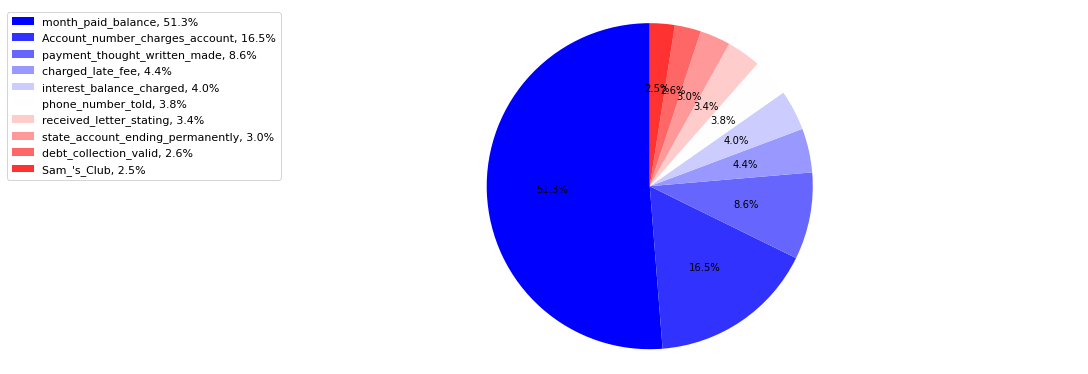

In [34]:
topic_names = topic_df['Topic Name'].head(10)
percentage = topic_df['Percentage'].head(10)
create_topic_pie_chart(list(percentage),list(topic_names))

In [35]:
# Most Important top N keywoprds & Phrases 
# See Top -5 Topics Keywords & Phrases 
import matplotlib.colors as mcolors
def create_keywords_dict(keywords):
    keywords_list =[]
    for keys in keywords:
        dic ={}
        for key in keys:
            key_value = key.split(',')
            dic[key_value[0].split('(')[0]] = float(key_value[1])
        keywords_list.append(dic)
    return keywords_list

def plot_wordcloud_top10_topics(keywords_list,topic_names):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cloud = WordCloud(background_color='white',width=2500,height=1800,max_words=10,colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
    fig, axes = plt.subplots(1,5, figsize=(25,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = keywords_list[i]
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(topic_names[i], fontdict=dict(size=16))

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()


#### Most Frequent Keywords & Phrases of top 5 Topics

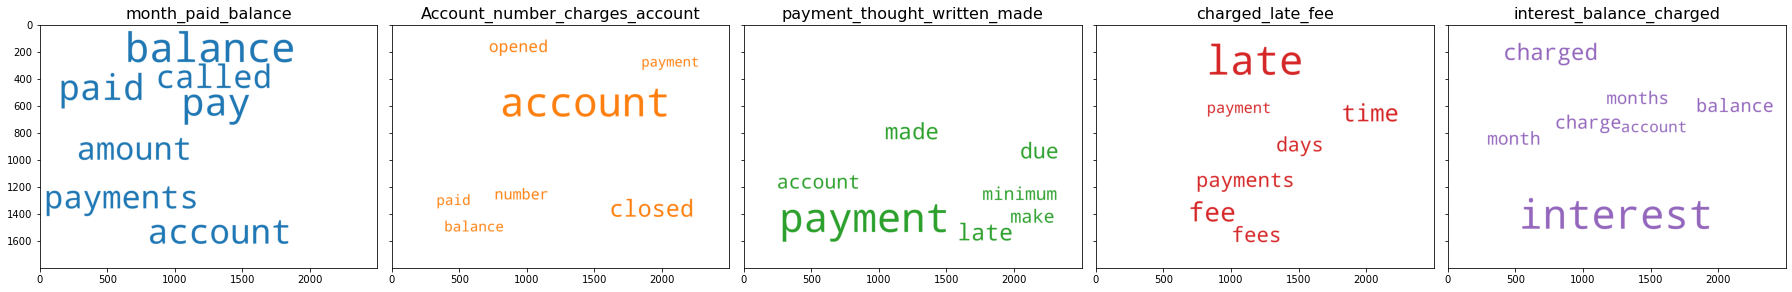

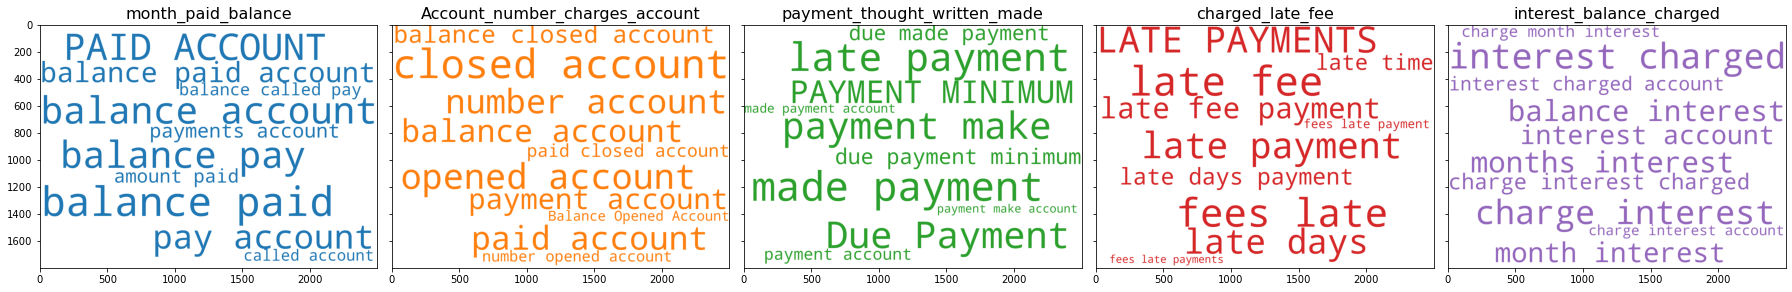

In [36]:

keywords = topic_df['Keywords'].head(5)
phrases = topic_df['Phrases'].head(5)
topic_names_val = topic_df['Topic Name'].head(5)
keywords_list =create_keywords_dict(keywords)
phrases_list =create_keywords_dict(phrases)
plot_wordcloud_top10_topics(keywords_list,list(topic_names_val))
plot_wordcloud_top10_topics(phrases_list,list(topic_names_val))


<a id="LDA"></a>
### LDA Topic Modeling

In [37]:
# Pre -processing steps for LDA modeling using WatsonNLP
docs =[]
def clean(doc):
    docs =[word.replace('X','').replace('/','') for word in doc.split() if word.lower() not in stop_words]
    return docs

In [38]:
import gensim
from gensim.corpora import Dictionary
top_doc_list_array = [clean(doc) for doc in top_doc_list]


/opt/conda/envs/Python-3.9-Premium/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [39]:
print(top_doc_list_array[0])

['Received', 'letter', '', 'stating', 'closed.', 'states', 'reason', '"', 'Activity', 'account', '(', ')', 'indicative', 'high', 'risk', 'failure', 'pay', "''.", 'date', 'closing,', '{$580.00}', 'cash', 'back.', 'called,', 'stated', 'close', 'account.', 'makes', 'sense', 'reason', 'legit', 'account', 'opened', '2', 'months.', 'limit', '{$15000.00}.', 'balance', '2021', '{$9900.00}', 'due', 'date', '.', 'entire', 'balanced', '{$9900.00}', 'paid', '', '(', 'transaction', 'detail', 'statement', ').', 'statement', 'balance', '{$0.00}', 'charged', 'paid', 'statement', 'close', 'date.', 'total', 'history', '2', 'months,', 'balance', '{$9900.00}', 'paid', '3', 'days', '20', 'days', 'due', 'date.', 'statement', 'balance', '.', 'sound', 'high', 'risk', 'mention', 'website', 'score', '', '(', 'attachment', 'score', ')', 'rated', 'excellent.', 'Information', 'provided', 'customer', 'service', 'rude', 'stated', 'close', 'account', 'reason.', 'closing', 'account', 'based', 'race', 'woman?', 'reason

In [40]:
dictionary = Dictionary(top_doc_list_array)
# Filter out words that occur less than 10 documents, or more than 30% of the documents.
print('Distinct words in initial documents:', len(dictionary))
#dictionary.filter_extremes(no_below=10, no_above=0.3)

print('Distinct words after removing rare and common words:', len(dictionary))

Distinct words in initial documents: 49822
Distinct words after removing rare and common words: 49822


In [41]:
%%capture
!pip install pyLDAvis

In [42]:
from gensim.models import CoherenceModel, LdaModel
#import pyLDAvis.gensim

corpus = [dictionary.doc2bow(doc) for doc in docs]
num_topics = 15

model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=50, workers=2)


In [43]:
print(model.print_topics()[0])
doc_lda = model[corpus]

(0, '0.000*"fix" + 0.000*"DIRECTLY," + 0.000*"National" + 0.000*"logo" + 0.000*"HAPPENED." + 0.000*"number:." + 0.000*"BOYCOTT," + 0.000*"TWICE!" + 0.000*"re-dispute." + 0.000*"PRECIOUS.AS"')


In [44]:
for topics in model.print_topics():
    print(topics)

(0, '0.000*"fix" + 0.000*"DIRECTLY," + 0.000*"National" + 0.000*"logo" + 0.000*"HAPPENED." + 0.000*"number:." + 0.000*"BOYCOTT," + 0.000*"TWICE!" + 0.000*"re-dispute." + 0.000*"PRECIOUS.AS"')
(1, '0.000*"directions." + 0.000*"persona." + 0.000*"divides" + 0.000*"replacedrepaired" + 0.000*"{$83.00}." + 0.000*"counters." + 0.000*"1.6.," + 0.000*"bill-paying" + 0.000*"File" + 0.000*"bylaws"')
(2, '0.000*"wave" + 0.000*"updated" + 0.000*"3-604" + 0.000*"codes." + 0.000*"mitigate" + 0.000*"town." + 0.000*"{$5900.00}," + 0.000*"grabbing" + 0.000*"fairly" + 0.000*"Co.,"')
(3, '0.000*"saving," + 0.000*"wrapped" + 0.000*"enjoys" + 0.000*"Portability" + 0.000*"-who" + 0.000*"2.5" + 0.000*"Policy," + 0.000*"bull," + 0.000*"Cust" + 0.000*"line15"')
(4, '0.000*"pick" + 0.000*"factors." + 0.000*"attorney," + 0.000*".Plus" + 0.000*"delinquint" + 0.000*"Sun," + 0.000*"awalamrt" + 0.000*"VM," + 0.000*"unverifiable." + 0.000*"case-by-case"')
(5, '0.000*"inquiries." + 0.000*"alike" + 0.000*"Arkansas." + 

In [45]:
model.print_topics(num_topics=15, num_words=10)

[(0,
  '0.000*"fix" + 0.000*"DIRECTLY," + 0.000*"National" + 0.000*"logo" + 0.000*"HAPPENED." + 0.000*"number:." + 0.000*"BOYCOTT," + 0.000*"TWICE!" + 0.000*"re-dispute." + 0.000*"PRECIOUS.AS"'),
 (1,
  '0.000*"directions." + 0.000*"persona." + 0.000*"divides" + 0.000*"replacedrepaired" + 0.000*"{$83.00}." + 0.000*"counters." + 0.000*"1.6.," + 0.000*"bill-paying" + 0.000*"File" + 0.000*"bylaws"'),
 (2,
  '0.000*"wave" + 0.000*"updated" + 0.000*"3-604" + 0.000*"codes." + 0.000*"mitigate" + 0.000*"town." + 0.000*"{$5900.00}," + 0.000*"grabbing" + 0.000*"fairly" + 0.000*"Co.,"'),
 (3,
  '0.000*"saving," + 0.000*"wrapped" + 0.000*"enjoys" + 0.000*"Portability" + 0.000*"-who" + 0.000*"2.5" + 0.000*"Policy," + 0.000*"bull," + 0.000*"Cust" + 0.000*"line15"'),
 (4,
  '0.000*"pick" + 0.000*"factors." + 0.000*"attorney," + 0.000*".Plus" + 0.000*"delinquint" + 0.000*"Sun," + 0.000*"awalamrt" + 0.000*"VM," + 0.000*"unverifiable." + 0.000*"case-by-case"'),
 (5,
  '0.000*"inquiries." + 0.000*"alike"

In [46]:
for doc1 in doc_lda:
    print(doc1)

(0, 0.06666667)
(1, 0.06666667)
(2, 0.06666667)
(3, 0.06666667)
(4, 0.06666667)
(5, 0.06666667)
(6, 0.06666667)
(7, 0.06666667)
(8, 0.06666667)
(9, 0.06666667)
(10, 0.06666667)
(11, 0.06666667)
(12, 0.06666667)
(13, 0.06666667)
(14, 0.06666667)


<a id="summary"></a>
## 7. Summary

<span style="color:blue">As per analsyis topic modeling on Consumer Finaanical database with Watson NLP & LDA  </span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 